In [44]:
# imports and loading
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from pymodulon.io import *
from os import path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

interim_dir = path.join('..','data','interim')
ica_data = load_json_model(path.join(interim_dir,'zmo_raw.json.gz'))
proteomics_df = pd.read_excel('../data/external/proteomics_10_3389_fmicb_2019_02596.XLSX', sheet_name = 'LFQ', index_col = 0)


# mid-glucose (T1, about 50% glucose utilized)
# late glucose (T2, about 5–10 g glucose/L remaining)
# early xylose (T3, ∼1 h after glucose was completely depleted)
# late xylose (T4, ∼24 h after glucose was completely depleted)
# let's focus on SynH3- samples, as I'm not particularlly interested in stressors
column_to_sample = {
    'LDI_early_glucose_fold_change' : 'lignocellulose_ferment:high_ACSH_early',
    'LDI_late_glucose_fold_change' : 'lignocellulose_ferment:high_ACSH_mid',
    'LDI_early_xylose_fold_change' : 'lignocellulose_ferment:high_ACSH_late',
    'LDI_late_xylose_fold_change' : 'lignocellulose_ferment:high_ACSH_stat',
    'no_LDI_early_glucose_fold_change' : 'lignocellulose_ferment:low_ACSH_early',
    'no_LDI_late_glucose_fold_change' : 'lignocellulose_ferment:low_ACSH_mid',
    'no_LDI_early_xylose_fold_change' : 'lignocellulose_ferment:low_ACSH_late',
    'no_LDI_late_xylose_fold_change' : 'lignocellulose_ferment:low_ACSH_stat',
}


sample_X_df = pd.DataFrame(index = ica_data.X.index)
for group_id, group_df in ica_data.sample_table.groupby('full_name'):
    sample_X_df[group_id] = ica_data.X[group_df.index].T.mean()


pentose_phosphate_pathway = 'map00030'

/tmp/ipykernel_17858/214364381.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sample_X_df[group_id] = ica_data.X[group_df.index].T.mean()
/tmp/ipykernel_17858/214364381.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sample_X_df[group_id] = ica_data.X[group_df.index].T.mean()
/tmp/ipykernel_17858/214364381.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) 

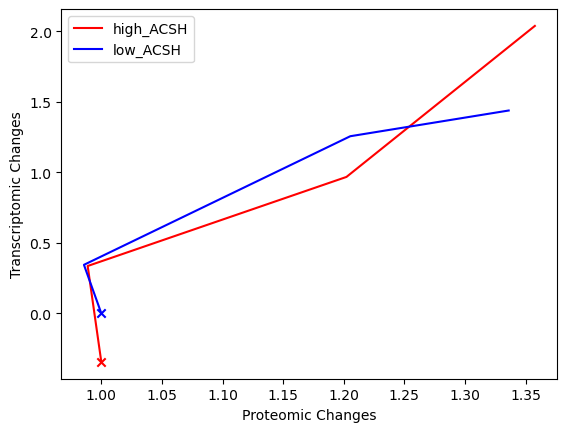

In [33]:
# let's look at expression, iM activity, and proteomics of the genes in question
gene = 'ZCP4_0707' # nitrogen fixation - ZCP4_1350, pentose phosphate pathway - ZCP4_1199, nitrogen uptake - ZCP4_0707
#prot_index = ica_data.gene_table.loc[gene].ZM4_locus.split('_')[1]
gene_changes = sample_X_df[column_to_sample.values()].loc[gene]
prot_changes = ica_data.gene_table.loc[gene][column_to_sample.keys()].rename(index = column_to_sample)
#proteomics_df.loc[prot_index].rename(index = column_to_sample)

order_1 = [
    'lignocellulose_ferment:high_ACSH_early', 
    'lignocellulose_ferment:high_ACSH_mid', 
    'lignocellulose_ferment:high_ACSH_late', 
    'lignocellulose_ferment:high_ACSH_stat',
]
order_2 = [
    'lignocellulose_ferment:low_ACSH_early', 
    'lignocellulose_ferment:low_ACSH_mid', 
    'lignocellulose_ferment:low_ACSH_late', 
    'lignocellulose_ferment:low_ACSH_stat'
]

plt.scatter(prot_changes.loc[order_1][0], gene_changes.loc[order_1][0], c = 'red', marker = 'x')
plt.scatter(prot_changes.loc[order_2][0], gene_changes.loc[order_2][0], c = 'blue', marker = 'x')
plt.plot(prot_changes.loc[order_1], gene_changes.loc[order_1], c = 'red', label = 'high_ACSH')
plt.plot(prot_changes.loc[order_2], gene_changes.loc[order_2], c = 'blue', label = 'low_ACSH')
plt.xlabel('Proteomic Changes')
plt.ylabel('Transcriptomic Changes')
plt.legend()
plt.show()

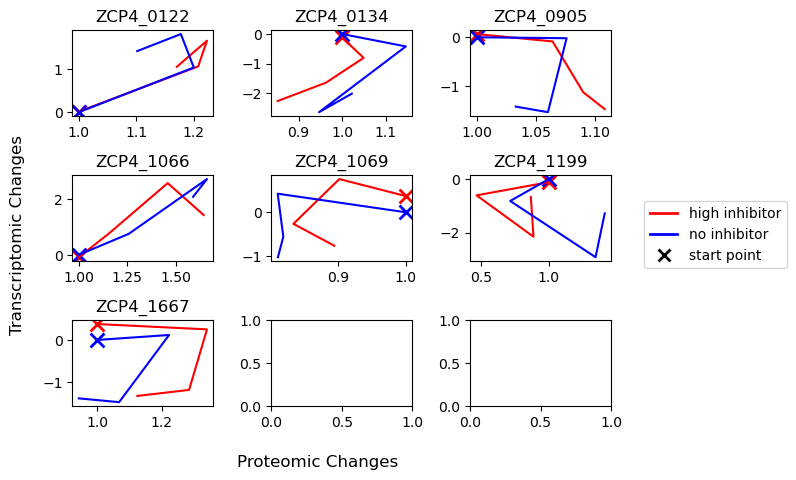

In [51]:
# pulled by looking at KEGG map
PPP_genes = [
    'ZCP4_0122', 'ZCP4_0134', 'ZCP4_0905', 'ZCP4_1066', 
    'ZCP4_1069', 'ZCP4_1199', 'ZCP4_1667', 
]
xylose_to_g3p_genes = [
    'ZCP4_1069', 'ZCP4_0134', 'ZCP4_1066', 'ZCP4_0801', 
]

fig, axs = plt.subplots(3,3)
ax_iter = iter(axs.flatten())
for gene in PPP_genes:
    ax = next(ax_iter)
    # let's look at expression, iM activity, and proteomics of the genes in question
    #prot_index = ica_data.gene_table.loc[gene].ZM4_locus.split('_')[1]
    gene_changes = sample_X_df[column_to_sample.values()].loc[gene]
    prot_changes = ica_data.gene_table.loc[gene][column_to_sample.keys()].rename(index = column_to_sample)
    #proteomics_df.loc[prot_index].rename(index = column_to_sample)
    
    order_1 = [
        'lignocellulose_ferment:high_ACSH_early', 
        'lignocellulose_ferment:high_ACSH_mid', 
        'lignocellulose_ferment:high_ACSH_late', 
        'lignocellulose_ferment:high_ACSH_stat',
    ]
    order_2 = [
        'lignocellulose_ferment:low_ACSH_early', 
        'lignocellulose_ferment:low_ACSH_mid', 
        'lignocellulose_ferment:low_ACSH_late', 
        'lignocellulose_ferment:low_ACSH_stat'
    ]

    ax.set_title(gene)
    ax.scatter(prot_changes.loc[order_1][0], gene_changes.loc[order_1][0], c = 'red', marker = 'x', lw = 2, s = 100)
    ax.scatter(prot_changes.loc[order_2][0], gene_changes.loc[order_2][0], c = 'blue', marker = 'x', lw = 2, s = 100)
    ax.plot(prot_changes.loc[order_1], gene_changes.loc[order_1], c = 'red', label = 'high_ACSH')
    ax.plot(prot_changes.loc[order_2], gene_changes.loc[order_2], c = 'blue', label = 'low_ACSH')
fig.supxlabel('Proteomic Changes')
fig.supylabel('Transcriptomic Changes')

# Create custom legend elements using Line2D and Patch
legend_handles = [
    Line2D([0], [0], color='red', lw=2, label='high inhibitor'),
    Line2D([0], [0], color='blue', lw=2, label='no inhibitor'),
    Line2D([0], [0], color='black', lw=0, marker='x', markersize=8, markeredgewidth=2, label='start point')
]
patch = Patch(color='yellow', label='Custom Patch')  # Example of a patch in the legend

# Combine the line and patch objects into a single legend
fig.legend(handles = legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()